# Twitter Dog Rating Project

## Table of Contents:


- [Introduction](#intro)
- [Part I - Wrangling the data](#data_wrangling)
    - [a. Gathering](#gathering)
    - [b. Assessing](#assessing)
    - [c. Cleaning](#cleaning)
    - [e. Exploring](#exploring)
- [Part II - Sentiment Analysis of `@dog_rates` tweets](#sentiment_analysis)
- [Conclusion](#conclusion)

<a id='intro'></a>
## Introduction

[#WeRateDogs](https://twitter.com/dog_rates) became an Internet sensation since the inception of the account in November 2015. It is a Twitter account that rates people's dogs on an unconventional scale and with a lot of humor. Known for its unique dog rating system and the creative dog "stages" (floofer, doggo, pupper, puppo, blep, snoot), it has gained incredible notoriaty and now counts 8.7 million followers on Twitter. It even led to the publication of a book in 2017, ['#WeRateDogs: The Most Hilarious and Adorable Pups You've Ever Seen'](https://www.amazon.com/WeRateDogs-Most-Hilarious-Adorable-Youve/dp/1510717145) by the creator of the account, Matt Nelson.

This project is divided into two parts. First, we will wrangle data from the `@dog_rates` account to prepare it for analysis. Then, we will perform sentiment analysis on the tweets to classify the type of sentiment: positive, neutral, or negative. **By analyzing the results and performing sentiment analysis, we seek to understand what type of tweets are more likely to be popular among the followers of the Twitter account `@dog_rates`.**

We will first gather the data from two different sources:

1. an archive of 2356 tweets from the `@dog_rates` account. The document comes in the form of a .csv text file.
2. Twitter's API - for each tweet in the archive (and if the tweet still lives on Twitter's servers), we will query the API to extract the retweet_count and favorite_count ("like" counts).

After cleaning and storing the clean dataset, we'll analyze and visualize the data to understand the characteristics of popular tweets before performing sentiment analysis.

<a id='data_wrangling'></a>
## Part I - Wrangling the Data

<a id='gathering'></a>
### a. Gathering

In [69]:
#import packages
import pandas as pd
import numpy as np
import requests
import tweepy
import os
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [70]:
#read .csv Twitter archive
twitter_archive = pd.read_csv \
('twitter-archive-enhanced.csv')

In [71]:
#API token info
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

#connect to Twitter API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [72]:
'''
Create lists of 100 tweet_ids each so that we can query 
tweet statuses from Twitter's API in batch (and avoid running
into Twitter's API rate limit).
'''

#convert `tweet_id` column to list
tweet_id_list = twitter_archive['tweet_id'].to_list()

#create sublists of 100 tweets each
start_index = 0
bucket_size = 100

tweet_ids_list_of_lists = []

while start_index < len(tweet_id_list):
    tweet_ids_list_of_lists.append(tweet_id_list[start_index : start_index + bucket_size])
    start_index += bucket_size

In [73]:
#append tweet info (queried in batches of 100 tweets) from Twitter api to list of lists
tweet_statuses_list_of_lists = []

for tweet_ids in tweet_ids_list_of_lists:
    tweet_statuses_list_of_lists.append(api.statuses_lookup(tweet_ids))

In [74]:
#flatten the lists
twitter_api = [status._json for tweet_ids in tweet_statuses_list_of_lists for status in tweet_ids]

In [75]:
# Serialize json object 
json_data = json.dumps(twitter_api, indent = 2) 
   
# Writing to tweet_json.txt 
with open("tweet_json.txt", "w") as new_file: 
    new_file.write(json_data) 

In [76]:
# read tweet_json.txt into pandas DataFrame & keep tweet_id, retweet_count, and favorite_count only
twitter_api = pd.read_json('tweet_json.txt')
twitter_api = twitter_api[['id','retweet_count','favorite_count']]
twitter_api.rename(columns={"id": "tweet_id"},inplace = True)

<a id='assessing'></a>
### b. Assessing

In [77]:
#merge datasets
df = pd.merge(twitter_archive, twitter_api, how='inner', on='tweet_id')

In [78]:
df.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,7705,36201


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2331 entries, 0 to 2330
Data columns (total 19 columns):
tweet_id                      2331 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2331 non-null object
source                        2331 non-null object
text                          2331 non-null object
retweeted_status_id           163 non-null float64
retweeted_status_user_id      163 non-null float64
retweeted_status_timestamp    163 non-null object
expanded_urls                 2272 non-null object
rating_numerator              2331 non-null int64
rating_denominator            2331 non-null int64
name                          2331 non-null object
doggo                         2331 non-null object
floofer                       2331 non-null object
pupper                        2331 non-null object
puppo                         2331 non-null object
retweet_count                 23

In [80]:
df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,retweet_count,favorite_count
count,2.331000e+03,7.800000e+01,7.800000e+01,1.630000e+02,1.630000e+02,2331.000000,2331.000000,2331.000000,2331.000000
mean,7.419079e+17,7.455079e+17,2.014171e+16,7.690768e+17,1.378818e+16,13.134706,10.459888,2703.632776,7556.836980
std,6.823170e+16,7.582492e+16,1.252797e+17,6.168036e+16,1.010910e+17,46.121847,6.781159,4571.678946,11729.636911
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000,1.000000,0.000000
25%,6.782670e+17,6.757419e+17,3.086374e+08,7.118465e+17,4.196984e+09,10.000000,10.000000,546.500000,1317.000000
50%,7.182469e+17,7.038708e+17,4.196984e+09,7.798343e+17,4.196984e+09,11.000000,10.000000,1267.000000,3285.000000
75%,7.986692e+17,8.257804e+17,4.196984e+09,8.190056e+17,4.196984e+09,12.000000,10.000000,3142.000000,9256.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.860537e+17,7.874618e+17,1776.000000,170.000000,77795.000000,156212.000000


In [81]:
df.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2253
in_reply_to_user_id           2253
timestamp                        0
source                           0
text                             0
retweeted_status_id           2168
retweeted_status_user_id      2168
retweeted_status_timestamp    2168
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
retweet_count                    0
favorite_count                   0
dtype: int64

In [82]:
df[df['name'].str[0].str.islower()]['name'].count() + df[df['name'] == 'None']['name'].count()

844

In [83]:
df[df["expanded_urls"].str.contains("https://twitter.com/dog_rates") == False].count()[0]

155

In [84]:
df.loc[df['retweeted_status_id'].notnull()].count()[0]

163

In [85]:
df.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2197
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      10
Name: source, dtype: int64

**Data quality issues:**
1. missing values
2. wrong data types
3. 844 dog names parsed incorrectly or non-existent
4. Some numerators and denominators extracted incorrectly
5. 163 tweets are retweets
6. 155 URLs are not dog photos
7. Dog stages not properly extracted
8. Gibberish contained in `source` column

**Data tidiness issues:**
1. dog stage columns are values not variables

<a id='cleaning'></a>
### c. Cleaning

#### 1. Changing datatypes

**Define** : `tweet_id`, `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, and `retweeted_status_user_id` need to be converted to string (or object) because we can't do any numerical analysis on those variables. Time `timestamp` and `retweeted_status_timestamp` need to be converted to a datetime datatype.

**Code**

In [86]:
df_clean = df.copy()

In [87]:
#convert int & float to object
df_clean = df_clean.astype({'tweet_id':'object','in_reply_to_status_id':'object',
                                    'in_reply_to_user_id': 'object','retweeted_status_id':'object',
                                   'retweeted_status_user_id': 'object'})

#convert object to datetime
df_clean[['timestamp', 'retweeted_status_timestamp']] = \
df_clean[['timestamp', 'retweeted_status_timestamp']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')

**Test**

In [88]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2331 entries, 0 to 2330
Data columns (total 19 columns):
tweet_id                      2331 non-null object
in_reply_to_status_id         78 non-null object
in_reply_to_user_id           78 non-null object
timestamp                     2331 non-null datetime64[ns, UTC]
source                        2331 non-null object
text                          2331 non-null object
retweeted_status_id           163 non-null object
retweeted_status_user_id      163 non-null object
retweeted_status_timestamp    163 non-null datetime64[ns, UTC]
expanded_urls                 2272 non-null object
rating_numerator              2331 non-null int64
rating_denominator            2331 non-null int64
name                          2331 non-null object
doggo                         2331 non-null object
floofer                       2331 non-null object
pupper                        2331 non-null object
puppo                         2331 non-null object
retweet_c

#### 2. Deleting retweets from the dataset

**Define** : Let's drop the rows where a tweet is actually a retweet so that we only perform analysis on the original text.

**Code**

In [89]:
df_clean = df_clean.loc[df_clean['retweeted_status_id'].isnull()]

**Test**

In [90]:
df_clean.loc[df_clean['retweeted_status_id'].notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count


#### 3. Deleting tweets that don't belong to the @WeRateDogs account

**Define** : As evidenced by the url domains, some tweets are actually from an entirely different account. Let's delete the rows where they appear

**Code**

In [91]:
df_clean = df_clean[df_clean["expanded_urls"].str.contains("https://twitter.com/dog_rates") == True]

**Test**

In [92]:
df_clean[df_clean["expanded_urls"].str.contains("https://twitter.com/dog_rates") == False]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count


#### 4. Replacing incorrectly parsed dog names

**Define** : Some dog names were either parsed incorrectly from the `text` column or don't exist (represented by 'None'). Let's replace the incorrectly parsed and inexistent dog names with 'no_name'.

**Code**

In [93]:
no_name_list = df_clean[df_clean['name'].str[0].str.islower()]['name'].to_list()

[df_clean['name'].replace(to_replace =[no_name_list], value = None, inplace = True) for name in no_name_list] 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

**Test**

In [94]:
df_clean.name.value_counts()

None       584
Oliver      12
Cooper      10
Charlie     10
Penny        9
          ... 
Karma        1
Gerbald      1
Cuddles      1
William      1
Mitch        1
Name: name, Length: 912, dtype: int64

#### 5. Replacing incorrectly parsed numerators and denominators

**Define** : Some numerators and denominators parsed from the `text` column failed to account for decimals. Let's retrieve the correct rating and then apply it to the `numerator` and `denominator` columns.

**Code**

In [95]:
rating = df_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)

In [96]:
rating.columns = ['rating_numerator', 'rating_denominator']

In [97]:
df_clean = df_clean.astype({'rating_numerator':'float64','rating_denominator':'float64'})

**Test**

In [98]:
print("'rating_numerator' datatype:" , df_clean.rating_numerator.dtype)
print("'rating_denominator' datatype:"  , df_clean.rating_denominator.dtype)

'rating_numerator' datatype: float64
'rating_denominator' datatype: float64


#### 6. Correctly parse dog stages from `text` column

**Define** : Some dog stages have been parsed incorrectly. Let's first correctly parse them into separate columns. We'll then join them into one column named `dog_stages`.

**Code**

In [99]:
df_clean['floofer'] = df_clean.text.str.lower().str.extract(r'([F-f]loof)', expand = True)
df_clean['doggo'] = df_clean.text.str.lower().str.extract(r'([D-d]oggo)', expand = True)
df_clean['pupper'] = df_clean.text.str.lower().str.extract(r'([P-p]upper)', expand = True)
df_clean['puppo'] = df_clean.text.str.lower().str.extract(r'([P-p]uppo)', expand = True)
df_clean['blep'] = df_clean.text.str.lower().str.extract(r'([B-b]lep)', expand = True)
df_clean['snoot'] = df_clean.text.str.lower().str.extract(r'([S-s]noot)', expand = True)

In [100]:
df_clean['dog_stages'] = df_clean[['floofer','doggo','pupper','puppo','blep','snoot']].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)

In [101]:
df_clean['dog_stages'].replace({'':None}, inplace = True)

In [102]:
#handle missing values
df_clean.loc[df_clean.dog_stages == '', 'dog_stages'] = np.nan

**Test**

In [103]:
df_clean.dog_stages.value_counts()

pupper          226
doggo            66
floof            34
puppo            26
doggo,pupper      9
blep              3
floof,doggo       2
doggo,puppo       2
floof,pupper      1
pupper,blep       1
Name: dog_stages, dtype: int64

#### 7. Delete dog stage variable columns

**Define** : The fact that there are 6 columns representing the various dog stages is a data tidiness issue. Now that we have properly extracted the dog stages, let's delete the extraneous columns that have been combined into one column entitled `dog_stages`.

**Code**

In [104]:
df_clean.drop(['floofer','doggo','pupper','puppo','blep','snoot'], axis = 1, inplace = True)

**Test**

In [105]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2330
Data columns (total 16 columns):
tweet_id                      1987 non-null object
in_reply_to_status_id         23 non-null object
in_reply_to_user_id           23 non-null object
timestamp                     1987 non-null datetime64[ns, UTC]
source                        1987 non-null object
text                          1987 non-null object
retweeted_status_id           0 non-null object
retweeted_status_user_id      0 non-null object
retweeted_status_timestamp    0 non-null datetime64[ns, UTC]
expanded_urls                 1987 non-null object
rating_numerator              1987 non-null float64
rating_denominator            1987 non-null float64
name                          1987 non-null object
retweet_count                 1987 non-null int64
favorite_count                1987 non-null int64
dog_stages                    370 non-null object
dtypes: datetime64[ns, UTC](2), float64(2), int64(2), object(10)


#### 8. Clean gibberish from `source` column

**Define** : Let's extract the source from the `source` column so that it's clearer to visualize.

**Code**

In [106]:
extract_source_list = [re.findall(r'(.*?\>(.*)<.*)', source) for source in df_clean['source']]

for extract_source in extract_source_list:
    df_clean['source'] = df_clean['source'].replace(extract_source, extract_source[0][1])

**Test**

In [107]:
df_clean.source.value_counts()

Twitter for iPhone    1949
Twitter Web Client      28
TweetDeck               10
Name: source, dtype: int64

In [108]:
#save the clean dataframe
twitter_archive_master = df_clean.to_csv('twitter_archive_master.csv', index=False)

In [109]:
twitter_data = pd.read_csv('twitter_archive_master.csv')

In [110]:
twitter_data.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,dog_stages
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,7705,36201,NaN


#### e. Exploring

Now that we have successfully wrangled twitter data of the @WeRateDogs account and stored the clean dataframe in a .csv file, let's now explore the cleaned dataset.

In [111]:
twitter_data['rating'] = twitter_data['rating_numerator'] / twitter_data['rating_denominator']

In [112]:
twitter_data['rating'].median()*10

11.0

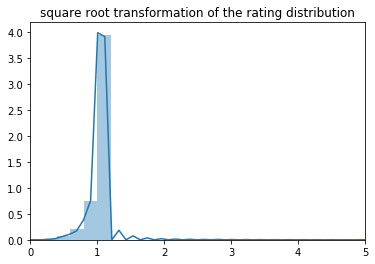

In [113]:
bins= np.arange(0,5+1/5, 1/5)
sns.distplot(np.sqrt(twitter_data["rating"]) ,bins = bins);
plt.xlim(0, 5)
plt.xlabel('')
plt.title('square root transformation of the rating distribution');

Using a square root transformation to reduce some of the data skewness, we visualized the `rating` column distribution. As becomes apparent, most ratings tend to be concentrated around 1.2-1.3 (the equivalent of 12/10 or 13/10). Dog owners seem to cherish their dogs to the point that they attibute an unconventially high rating!

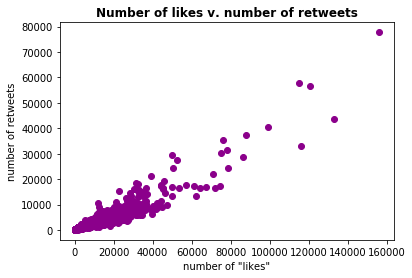

In [114]:
plt.scatter(data = twitter_data, x = 'favorite_count', y = 'retweet_count', c = 'darkmagenta');
plt.xlabel('number of "likes"');
plt.ylabel('number of retweets');
plt.title('Number of likes v. number of retweets', fontweight = 'bold');

In [115]:
twitter_data.favorite_count.corr(twitter_data.retweet_count)

0.9290732486192403

From the scatterplot above, we notice that `favorite_count` and `retweet_count` are variables that have a strong positive correlation (with a coefficient of approx. 0.93). We can conclude that there is a strong chance that tweets with the most "likes" will be retweeted. There is one data point that seems to stick out. Let's isolate that datapoint to see what makes it stand out above the rest of the dogs portrayed in the @rate_dogs account.

In [116]:
most_popular_dog_url = twitter_data.loc[twitter_data.favorite_count == 
                                        twitter_data.favorite_count.max()].values[0][10]

In [117]:
#Tweet class initially defined here: https://github.com/jupyter/notebook/issues/2790
class Tweet(object):
    def __init__(self, embed_str=None):
        self.embed_str = embed_str

    def _repr_html_(self):
        return self.embed_str

In [118]:
Tweet("""
<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Here&#39;s a doggo realizing you can stand in a pool. 
13/10 enlightened af (vid by Tina Conrad) <a href="https://t.co/7wE9LTEXC4">pic.twitter.com/7wE9LTEXC4</a></p>&mdash; 
WeRateDogs® (@dog_rates) <a href="https://twitter.com/dog_rates/status/744234799360020481?ref_src=twsrc%5Etfw">
June 18, 2016</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
""")

Well isn't he cute?!! That doggo definitely deserved the attention he got on Twitter. I wonder if videos are more popular than photos... let's find out.

In [119]:
twitter_data['photo_or_video'] = pd.np.where(twitter_data.expanded_urls.str.contains("photo"), "photo",
                               pd.np.where(twitter_data.expanded_urls.str.contains("video"), "video",None))

In [120]:
twitter_data.photo_or_video.value_counts(normalize = True)

photo    0.962758
video    0.037242
Name: photo_or_video, dtype: float64

In [121]:
twitter_data.groupby('photo_or_video')['retweet_count','favorite_count'].mean()

,retweet_count,favorite_count
photo_or_video,,
photo,2219.211187,7793.985886
video,8566.635135,20554.891892


While videos represent a small percentage of tweets (approx. 0.04%), they tend to be "liked" and retweeted a lot more than photos. On average, videos get 20,555 likes compared to 7,794 for photos, representing 2.64 more likes. They also get 8,567 retweets on average, compared to 2,219 for photos, representing about 3.86 more retweets than for photos. We can also visualize the information using the same scatterplot as above, adding a third variable ('photo' or 'video').

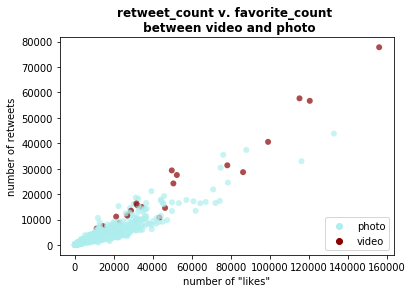

In [122]:
colors = {'photo':'#AFEEEE','video':'#8B0000'}

ax = sns.scatterplot(x="favorite_count", y="retweet_count",
                hue="photo_or_video",
                palette=colors,
                linewidth=0,
                data=twitter_data,
                alpha = 0.7)

handles,labels = ax.get_legend_handles_labels()

plt.legend(fancybox=True, shadow=True)
ax.legend(handles=handles[1:], labels=labels[1:], loc = 4)

plt.title('retweet_count v. favorite_count \n between video and photo', fontweight = 'bold')
plt.xlabel('number of "likes"');
plt.ylabel('number of retweets');
plt.show()

## Part II - Sentiment Analysis of `@dog_rates` tweets

Now that we have explored basic characteristics of the dataset, let's perform sentiment analysis on the @dog_rates tweets.

In [123]:
#delete rating and url from text
pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
twitter_data['text'] = [pattern.sub('', tweet) for tweet in twitter_data['text']]
twitter_data['text'] = twitter_data['text'].str.replace(r'((?:\d+\.)?\d+)\/(\d+)', '')

#trim text
twitter_data['text'] = twitter_data['text'].str.lstrip().str.rstrip()

In [124]:
twitter_mask = np.array(Image.open("twitter_logo.png"))

In [125]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

In [126]:
#create new mask that can be used with function defined above
transformed_twitter_mask = np.ndarray((twitter_mask.shape[0],twitter_mask.shape[1]), np.int32)

for i in range(len(twitter_mask)):
    transformed_twitter_mask[i] = list(map(transform_format, twitter_mask[i]))

In [127]:
stopwords = set(STOPWORDS)

#create & generate wordcloud image
wc = WordCloud(background_color="white", mask=transformed_twitter_mask,
               stopwords=stopwords, contour_width=2, contour_color='#00acee')
wc = wc.generate(' '.join(twitter_data['text']))

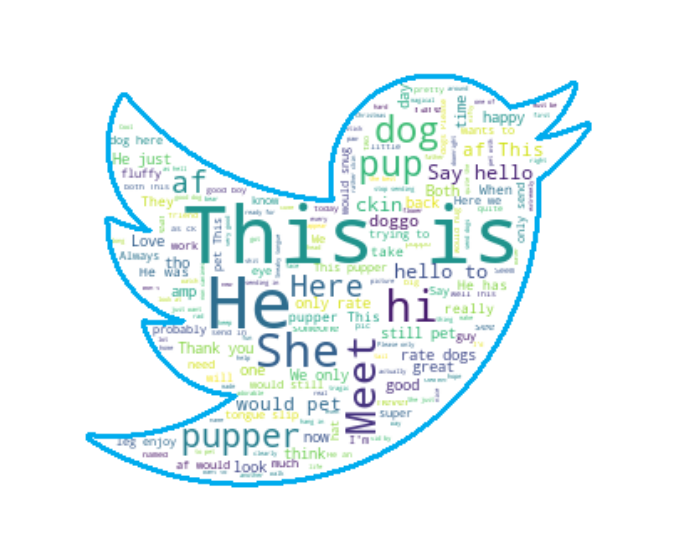

In [128]:
#show wordcloud
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [129]:
#store word cloud in .png file
wc.to_file \
("dog_rates_wordcloud.png");

We see from the wordcloud that the tweets use positive terms to describe the dogs: 'love', 'happy', 'great', 'hug', 'well', 'enjoy' to name a few. Now that we have performed basic text analysis on the `text` column of the dataset, let's dive deeper by classifying the sentiments associated with each tweet. We'll first attribute a sentiment classification score for each tweet using the Natural Language Toolkit (nltk) library and we'll then attribute categories ('Negative', 'Neutral', 'Positive') to the sentiment intensity scores based on a range. We use a compound score, which is a unidimensional normalized and weighted measure of sentiment. See [here](https://github.com/cjhutto/vaderSentiment) for more information on the way that it's calculated.

In [130]:
def sentiment_value(paragraph):
    analyser = SentimentIntensityAnalyzer()
    result = analyser.polarity_scores(paragraph)
    score = result['compound']
    return round(score,2)

In [131]:
#create new column with associated sentiment intensity score
twitter_data['sentiment_value'] = [sentiment_value(text) for text in twitter_data['text']]

In [132]:
#categorize sentiment types on a scale of -1 (very negative) to 1 (very positive)
sentiment = []

for sentiment_value in twitter_data['sentiment_value']:
    if (sentiment_value<=1 and sentiment_value>=0.5):
        sentiment.append('Very Positive')
    elif (sentiment_value<0.5 and sentiment_value>0):
        sentiment.append('Positive')
    elif (sentiment_value==0):
        sentiment.append('Neutral')
    elif (sentiment_value<0 and sentiment_value>=-0.5):
        sentiment.append('Negative')
    else:
        sentiment.append('Very Negative')

In [133]:
twitter_data['sentiment'] = sentiment

In [134]:
twitter_mask = twitter_data.sentiment.value_counts(normalize 
                                                   = True).reindex(['Very Positive', 
                                                                    'Positive','Neutral', 'Negative','Very Negative'])
twitter_mask

Very Positive    0.290388
Positive         0.251132
Neutral          0.183694
Negative         0.183191
Very Negative    0.091595
Name: sentiment, dtype: float64

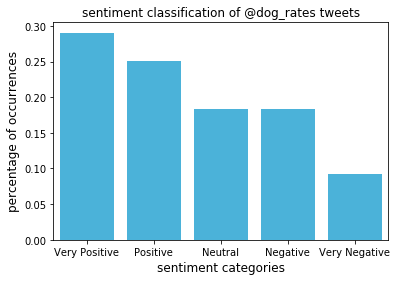

In [135]:
sns.barplot(twitter_mask.index, twitter_mask.values, alpha=0.8, 
            color = '#00acee')
plt.title('sentiment classification of @dog_rates tweets')
plt.ylabel('percentage of occurrences', fontsize=12)
plt.xlabel('sentiment categories', fontsize=12)
plt.show();

Not surprisingly, there seems to be a higher percentage of tweets conveying a 'very positive' sentiment. I'm still surprised to see that 18% and 9% of tweets convey 'negative' and 'very negative' sentiments, respectively. To answer our original question about tweet popularity, let's do some analysis to see what tweets are more popular based on the sentiment conveyed in the message.

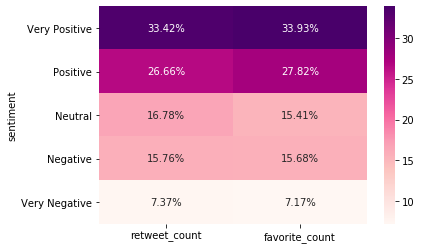

In [136]:
twitter_sentiment_mask = twitter_data.groupby('sentiment')['retweet_count','favorite_count'].sum().apply(lambda x:
                                                 100* x / float(x.sum()))

twitter_sentiment_mask = twitter_sentiment_mask.reindex(['Very Positive', 'Positive','Neutral',
                                                         'Negative','Very Negative'])
fig, ax = plt.subplots(1,1)
ax = sns.heatmap(twitter_sentiment_mask, annot = twitter_sentiment_mask.values, fmt = '.2f', cmap = 'RdPu')

for t in ax.texts: 
    t.set_text(t.get_text() + "%")

plt.show()

From the heatmap above, we see that the more positive the tweet language is, the more it will be liked or retweeted.

<a id='conclusion'></a>
## Conclusion

After wrangling the datasets containing information about the @WeRateDogs account, we proceeded to performing Exploratory Data Analysis to uncover certain insights. We found out that:
1. There's a strong positive correlation between "likes" and retweets (correlation coefficient: 0.93). The more "likes" a photo or a video receives, the more retweets the photo or video will get.
2. Videos are more popular than photos: they get 2.64 more likes than photos and 3.86 more retweets.
3. Using sentiment analysis tools, we are able to confirm that the more positive a tweet language is, the more popular it is.